# Working with IBL atlas object

## Getting started

The Allen atlas image and annotation volumes can be accessed using the `ibllib.atlas.AllenAtlas` class. Upon instantiating the class for the first time, the relevant files will be downloaded from the Allen database.

In [35]:
from ibllib.atlas import AllenAtlas

res = 25 # resolution of Atlas, available resolutions are 10, 25 (default) and 50
brain_atlas = AllenAtlas(res_um=res)

## Exploring the volumes

The brain_atlas class contains two volumes, the diffusion weighted imaging *(DWI) image* volume and the *annotation label* volume.
Each volume is saved into a matrix of the same shape (i.e. they contain the same number of voxels), as defined by the input resolution `res`.

### 1. Image Volume 
The image volume contains the Allen atlas DWI average template. DWI images are typically represented in gray-scale colors.

Shape of image volume: (528, 456, 320)


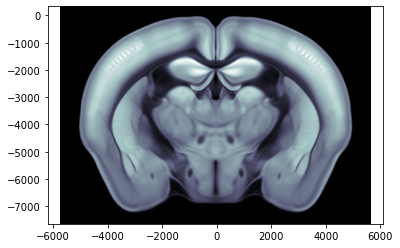

In [36]:
# Access the image volume
im = brain_atlas.image

# Explore the size of the image volume (ap, ml, dv)
print(f'Shape of image volume: {im.shape}')

# Plot a coronal slice at ap = -1000um
ap = -1000 / 1e6  # input must be in metres
ax = brain_atlas.plot_cslice(ap, volume='image')


### Label Volume


The label volume contains information about which brain region each voxel in the volume belongs to.

Shape of label volume: (528, 456, 320)


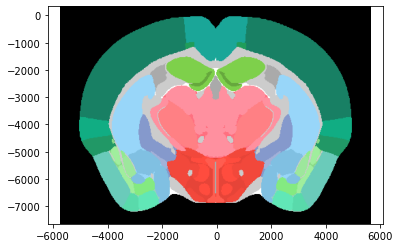

In [37]:
# Access the label volume
lab = brain_atlas.label

# Explore the size of the label volume (ap, ml, dv)
print(f'Shape of label volume: {lab.shape}')

# Plot a coronal slice at ap = -1000um
ap = -1000 / 1e6  # input must be in metres
ax = brain_atlas.plot_cslice(ap, volume='annotation')

The label volume used in the IBL AllenAtlas class differs from the Allen annotation volume in two ways.
- Each voxel has information about the index of the Allen region rather than the Allen atlas id
- The volume has been lateralised to differentiate between the left and right hemisphere

To understand this better let's explore the BrainRegions class that contains information about the Allen structure tree.

## Exploring brain regions

### Index versus Allen ID

The Allen brain region structure tree can be accessed through the class `ibllib.atlas.regions.BrainRegions`.

In [38]:
from ibllib.atlas.regions import BrainRegions

brain_regions = BrainRegions()

# Alternatively if you already have the AllenAtlas instantiated you can access it as an attribute
brain_regions = brain_atlas.regions

The brain_regions class has the following data attributes

In [39]:
brain_regions.__annotations__

{'id': numpy.ndarray,
 'name': object,
 'acronym': object,
 'rgb': numpy.uint8,
 'level': numpy.ndarray,
 'parent': numpy.ndarray,
 'order': numpy.uint16}

These attributes are the same as the Allen structure tree and for example `id` corresponds to the Allen atlas id while the `name` represents the full anatomical brain region name.

The index refers to the index in each of these attribute arrays. For example, index 1 corresponds to the `root` brain region with an atlas id of 977. 

In [40]:
index = 1
print(brain_regions.id[index])
print(brain_regions.acronym[index])

997
root


Alternatively, index 1000 corresponds to `PPYd` with an atlas id of 185

In [41]:
index = 1000
print(brain_regions.id[index])
print(brain_regions.acronym[index])

185
PPYd


In the label volume we described above, it is these indices that we are referring to. Therefore, we know all voxels in the volume with a value of 0 will be voxels that lie in `root`, while the voxels that have a value of 1000 will be in `PPYd`

In [42]:
import numpy as np
root_voxels = np.where(brain_atlas.label == 1)
ppyd_voxels = np.where(brain_atlas.label == 1000)

Voxels outside of the brain are labelled with `void`, which has the both the index and Allen ID being 0:

In [43]:
index_void = 0
print(brain_regions.id[index_void])
print(brain_regions.acronym[index_void])

0
void


As such, you can find all the voxels within the brain by filtering for non-zero indices:

In [44]:
vox_in = np.where(brain_regions.id != index_void)

### Lateralisation: left/right hemisphere differentiation

An additional nuance is the lateralisation. If you compare the size of the brain_regions data class to the Allen structure tree, you will see that it has double the number of columms. This is because the IBL brain regions encodes both the left and right hemisphere using unique, positive integers (the index), whilst the Allen IDs are signed integers (the sign represents the left or right hemisphere).

In [45]:
# Print how many indexes there are
print(brain_regions.id.size)

2655


This is equivalent to 2x the number of unique Allen IDs (positive + negative), plus `void` (0) that is not lateralised:

In [46]:
positive_id = np.where(brain_regions.id>0)[0]
negative_id = np.where(brain_regions.id<0)[0]
void_id = np.where(brain_regions.id==0)[0]

print(len(positive_id) + len(negative_id) + len(void_id))

2655


We can understand this better by exploring the `brain_regions.id` and `brain_regions.name` at the indices where it transitions between hemispheres.

The first value of `brain_region.id` is `void` (Allen id `0`):

In [47]:
print(brain_regions.id[index_void])

0


The point of change between right and left hemisphere is at the index:

In [48]:
print(len(positive_id))

1327


Around this index, the `brain_region.id` go from positive Allen atlas ids (right hemisphere) to negative Allen atlas ids (left hemisphere).

In [49]:
print(brain_regions.id[1320:1340])

[        25         34         43         49         57         65
        624  304325711       -997         -8       -567       -688
       -695       -315       -184        -68       -667 -526157192
 -526157196 -526322264]


Regions are organised following the same index ordering in left/right hemisphere.
For example, you will find the same acronym `PPYd` at the index 1000, and once you've passed the positive integers:

In [50]:
index = 1000
print(brain_regions.acronym[index])
print(brain_regions.acronym[index + len(positive_id)])
# Note: do not re-use this approach, this is for explanation only - you will see below a dedicated function

PPYd
PPYd


The `brain_region.name` also go from right to left hemisphere:

In [51]:
print(brain_regions.name[1320:1340])

['simple fissure' 'intercrural fissure' 'ansoparamedian fissure'
 'intraparafloccular fissure' 'paramedian sulcus' 'parafloccular sulcus'
 'Interpeduncular fossa' 'retina' 'root (left)'
 'Basic cell groups and regions (left)' 'Cerebrum (left)'
 'Cerebral cortex (left)' 'Cortical plate (left)' 'Isocortex (left)'
 'Frontal pole cerebral cortex (left)' 'Frontal pole layer 1 (left)'
 'Frontal pole layer 2/3 (left)' 'Frontal pole layer 5 (left)'
 'Frontal pole layer 6a (left)' 'Frontal pole layer 6b (left)']


In the label volume, we can therefore differentiate between left and right hemisphere voxels for the same brain region. First we will use a method in the brain_region class to find out the index of left and right `CA1`.

In [52]:
brain_regions.acronym2index('CA1')
# The first values are the acronyms, the second values are the indices

(array(['CA1'], dtype=object), [array([ 458, 1785])])

The method `acronym2index` returns a tuple, with the first value being a list of acronyms passed in and the second value giving the indices in the array that correspond to the left and right hemispheres for this region. We can now use these indices to search in the label volume

In [53]:
CA1_right = np.where(brain_atlas.label == 458)
CA1_left = np.where(brain_atlas.label == 1785)

## Navigate the brain region hierarchy
The 1327 labels within the brain in the Allen parcelation are organised in a hierarchical tree.
For example, the region PPY encompasses both the regions PPYd and PPYs.

You can visually explore the hierarchy through this [webpage](https://openalyx.internationalbrainlab.org/admin/experiments/brainregion/) (username: `intbrainlab`, password: `international`).
(TODO THIS IS NOT A GREAT WAY, CHANGE TO OTHER REFERENCE)


### Ancestors

To find ancestors of a region, i.e. regions that are higher in the hierarchy tree, use `brain_regions.ancestors`.

Let's use the region PPYd as an example:

In [54]:
index = 1000  # Remember the Allen id at this index is 185
brain_regions.ancestors(ids=brain_regions.id[index])

{'id': array([ 997,    8,  343, 1065,  354,  370, 1069,  185]),
 'name': array(['root', 'Basic cell groups and regions', 'Brain stem', 'Hindbrain',
        'Medulla', 'Medulla motor related', 'Parapyramidal nucleus',
        'Parapyramidal nucleus deep part'], dtype=object),
 'acronym': array(['root', 'grey', 'BS', 'HB', 'MY', 'MY-mot', 'PPY', 'PPYd'],
       dtype=object),
 'rgb': array([[255, 255, 255],
        [191, 218, 227],
        [255, 112, 128],
        [255, 155, 136],
        [255, 155, 205],
        [255, 179, 217],
        [255, 179, 217],
        [255, 179, 217]], dtype=uint8),
 'level': array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint16),
 'parent': array([  nan,  997.,    8.,  343., 1065.,  354.,  370., 1069.]),
 'order': array([  0,   1, 639, 882, 935, 964, 998, 999], dtype=uint16)}

All parents along the hierarchy tree are returned.
The parents are organised in increasing order of `level` (0-1-2...), i.e. the highest, all-encompassing level is first (`root` in the example above).
Note:
- The fields contain all the parents regions, including the one passed in (which is last).
- The field `parent` returns the parent region id of the regions in `id` (you can notice they are the same as in `id` but incremented by one level).

TODO WHAT IS ORDER ? IT IS NOT THE BELOW (see middle values)

- The field `order` returns the index of the region in the field `parent`.

For example, the last `parent` region is PPY (which is indeed the closest parent of PPYd):

In [55]:
index = 999
print(brain_regions.id[index])
print(brain_regions.acronym[index])

1069
PPY


### Descendants
To find the descendants of a region, use `brain_regions.descendants`.

Let's use the region PPY as an example:

In [56]:
index = 999
brain_regions.descendants(ids=brain_regions.id[index])

{'id': array([1069,  185,  193]),
 'name': array(['Parapyramidal nucleus', 'Parapyramidal nucleus deep part',
        'Parapyramidal nucleus superficial part'], dtype=object),
 'acronym': array(['PPY', 'PPYd', 'PPYs'], dtype=object),
 'rgb': array([[255, 179, 217],
        [255, 179, 217],
        [255, 179, 217]], dtype=uint8),
 'level': array([6, 7, 7], dtype=uint16),
 'parent': array([ 370., 1069., 1069.]),
 'order': array([ 998,  999, 1000], dtype=uint16)}

Note:
- The fields contain all the descendant regions, including the one passed in (which is first).
- The field `parent` returns the parent region id of the regions in `id`.

TODO THIS IS WRONG :
- The field `order` returns the index of the region in the field `parent`.

### Find region at a particular place in the hierarchy

#### Leaf node

If you need to check a region is a leaf node, i.e. that it has no descendant, check that the returned length of the parents is one (i.e. it only returns itself) from the `descendants` method.

For example, PPYd is a leaf node:

In [57]:
index = 1000
ppyd_desc = brain_regions.descendants(ids=brain_regions.id[index])

len(ppyd_desc['parent']) == 1

True

To find all the regions that are leaf nodes, use `brain_regions.leaves`:

In [58]:
brain_regions.leaves()

{'id': array([-614454277, -607344862, -607344858, ...,  607344858,  607344862,
         614454277]),
 'name': array(['Supraoculomotor periaqueductal gray (left)',
        'Interpeduncular nucleus rostrolateral (left)',
        'Interpeduncular nucleus dorsolateral (left)', ...,
        'Interpeduncular nucleus dorsolateral',
        'Interpeduncular nucleus rostrolateral',
        'Supraoculomotor periaqueductal gray'], dtype=object),
 'acronym': array(['Su3', 'IPRL', 'IPDL', ..., 'IPDL', 'IPRL', 'Su3'], dtype=object),
 'rgb': array([[255, 144, 255],
        [255, 166, 255],
        [255, 166, 255],
        ...,
        [255, 166, 255],
        [255, 166, 255],
        [255, 144, 255]], dtype=uint8),
 'level': array([6, 7, 7, ..., 7, 7, 6], dtype=uint16),
 'parent': array([-795., -100., -100., ...,  100.,  100.,  795.]),
 'order': array([842, 878, 877, ..., 877, 878, 842], dtype=uint16)}

#### First-level parent regions

To find all the regions that are on level 0 of the hierarchy, use... TODO (show code to get particular level)

## Coordinate systems

The voxels can be translated to 3D space.
In the IBL, all xyz coordinates are referenced from Bregma, which point is set as xyz coordinate [0,0,0].

![IBL coordinate system](https://github.com/int-brain-lab/ibllib/blob/atlas_docs/examples/atlas/images/brain_xyz.png)

In contrast, in the Allen coordinate framework, the [0,0,0] point corresponds to one of the cubic volume edge.

Below we show the value of Bregma in the Allen CCF space (in micrometer um):

In [59]:
from ibllib.atlas import ALLEN_CCF_LANDMARKS_MLAPDV_UM
print(ALLEN_CCF_LANDMARKS_MLAPDV_UM)

{'bregma': array([5739, 5400,  332])}


To translate this into an index into the volume `brain_atlas`, you need to devide by the atlas resolution (also in micrometer):

In [60]:
# Find bregma position in indices
bregma_index = ALLEN_CCF_LANDMARKS_MLAPDV_UM['bregma'] / brain_atlas.res_um

This index can be passed into `brain_atlas.bc.i2xyz` that converts indices into IBL xyz coordinates (i.e. relative to Bregma):

In [61]:
# Find bregma position in xyz in m (expect this to be 0 0 0)
bregma_xyz = brain_atlas.bc.i2xyz(bregma_index)
print(bregma_xyz)

[0. 0. 0.]


Functions exist in both direction, i.e. from a volume index to IBL xyz, and from xyz to an index.
Note that the functions return/input values are in *meters*, not micrometers.

In [62]:
# Convert from arbitrary index to xyz position (m) position relative to Bregma
index = np.array([102, 234, 178]).astype(float)
xyz = brain_atlas.bc.i2xyz(index)
print(f'xyz values are in meters: {xyz}')

# Convert from xyz position (m) to index in atlas
xyz = np.array([-325, 4000, 250]) / 1e6
index = brain_atlas.bc.xyz2i(xyz)

xyz values are in meters: [-0.003189 -0.00045  -0.004118]


To know the sign and voxel resolution for each xyz axis, use:

In [70]:
# Find the resolution (in meter) of each axis
res_xyz = brain_atlas.bc.dxyz

# Find the sign of each axis
sign_xyz = np.sign(res_xyz)

print(f"Resolution xyz: {res_xyz} in meter \nSign xyz:\t\t{sign_xyz}")

Resolution xyz: [ 2.5e-05 -2.5e-05 -2.5e-05] in meter 
Sign xyz:		[ 1. -1. -1.]


To jump directly from an Allen xyz value to an IBL xyz value, use `brain_atlas.ccf2xyz`:

In [64]:
# Example: Where is the Allen 0 relative to IBL Bregma?
# This will give the Bregma value shown above (in meters), but with opposite axis sign value
brain_atlas.ccf2xyz(np.array([0, 0, 0]))

array([-0.005739,  0.0054  ,  0.000332])